In [1]:
# Importing the libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

In [3]:
# Creating objects to detect the face
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')

### Using the data augmentation technique
We make use of data augmentation technique to improve the quality of images and to increase the number of images in dataset. This data augmentation function returns 6 images with slight variation in all of them, thus to bring more versatality to the dataset. 

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
def img_augment(img):
    img_aug = []
    datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=45, 
                                 brightness_range=[0.2,1.5])
    data = img_to_array(img)
    # expand dimension to one sample
    samples = expand_dims(data, 0)
    # prepare iterator
    it = datagen.flow(samples, batch_size=1)
    # generate samples and plot
    for i in range(5):
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')
        img_aug.append(image)
    img_aug.append(img)
    return img_aug


Using TensorFlow backend.


### Creating dataset by capturing 300 face images of a subject
If you don't have a prior dataset, you can use this piece of code to create your own dataset

### Reading and preprocessing images

#### When dataset for different subjects is stored in different directories

#### When dataset stored in single directory
Reading images when data from all subjects is stored in single directory 

In [51]:
# Function defined to read image data and resize it to (224,224)
def pre_process(file_name, path):
    IMG_SHAPE = 224
    if file_name.endswith(".jpg") or file_name.endswith(".jpeg"):
        img = cv2.imread(pa + "\\"+file_name)
        img =  cv2.resize(img, (IMG_SHAPE,IMG_SHAPE), interpolation = cv2.INTER_AREA)
    return img

In [53]:
# Reading image dataset
images = []
labels = []
indice = 0
boolean = 1
pa = 'C:\\Users\\rajpu\\Desktop\\dataset\\face_dataset'
for file_name in os.listdir(pa):
    if file_name.startswith("meet"):
        label = 0
        img = pre_process(file_name, pa)
    elif file_name.startswith("paras"):
        label = 1
        img = pre_process(file_name, pa)
    elif file_name.startswith("sahil"):
        label = 2
        img = pre_process(file_name, pa)

    images.append(img)
    labels.append(label)
    indice = indice + 1


In [55]:
# Calling the data augmentation function
img = []
X = []
y = []
for j,image in tqdm(enumerate(images)):
    img = img_augment(image)
    for i in img:
        X.append(i)
        y.append(labels[j])

889it [00:46, 19.18it/s]


In [57]:
# Reshaping images
IMG_SHAPE = 224
n=len(X)

data_images = np.zeros((n,IMG_SHAPE,IMG_SHAPE,3),dtype=np.float32)
data_labels = np.zeros((n),dtype=np.float32)

i = 0
for item in range(len(X)):
    data_images[i,:,:,:] = X[item]/223
    data_labels[i] = y[item]
    i = i+1

In [59]:
# Splitting the dataset into training and testing

from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(data_images, data_labels, test_size=0.1, random_state=42)


## Creating Model

In [60]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.utils import to_categorical

In [61]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        7

In [62]:
model.compile(optimizer = keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
model.fit(X_train, y_train, batch_size=5, epochs=10, validation_split=0.20)

Epoch 1/10
768/768 [==============================] - 117s 150ms/step - loss: 0.6165 - accuracy: 0.7278 - val_loss: 0.1734 - val_accuracy: 0.9479
Epoch 2/10
768/768 [==============================] - 116s 152ms/step - loss: 0.1317 - accuracy: 0.9544 - val_loss: 0.0541 - val_accuracy: 0.9833
Epoch 3/10
768/768 [==============================] - 117s 153ms/step - loss: 0.0519 - accuracy: 0.9833 - val_loss: 0.0438 - val_accuracy: 0.9844
Epoch 4/10
768/768 [==============================] - 112s 146ms/step - loss: 0.0443 - accuracy: 0.9846 - val_loss: 0.0494 - val_accuracy: 0.9833
Epoch 5/10
768/768 [==============================] - 112s 146ms/step - loss: 0.0209 - accuracy: 0.9925 - val_loss: 0.0255 - val_accuracy: 0.9906
Epoch 6/10
768/768 [==============================] - 115s 149ms/step - loss: 0.0218 - accuracy: 0.9924 - val_loss: 0.0261 - val_accuracy: 0.9917
Epoch 7/10
768/768 [==============================] - 121s 157ms/step - loss: 0.0138 - accuracy: 0.9955 - val_loss: 0.0207 -

In [64]:
model.save("C:\\Users\\rajpu\\Desktop\\dataset\\models\\model.h5")

In [76]:
y_pred = model.predict(X_test, batch_size = 5 )
y_pred = list(y_pred)

In [82]:
y_output = []
for i in range(len(y_pred)):
    max_val = max(y_pred[i])
    max_val_ind = list(y_pred[i]).index(max_val)
    y_output.append(max_val_ind)


### Plotting the confusion matrix

<Figure size 432x288 with 0 Axes>

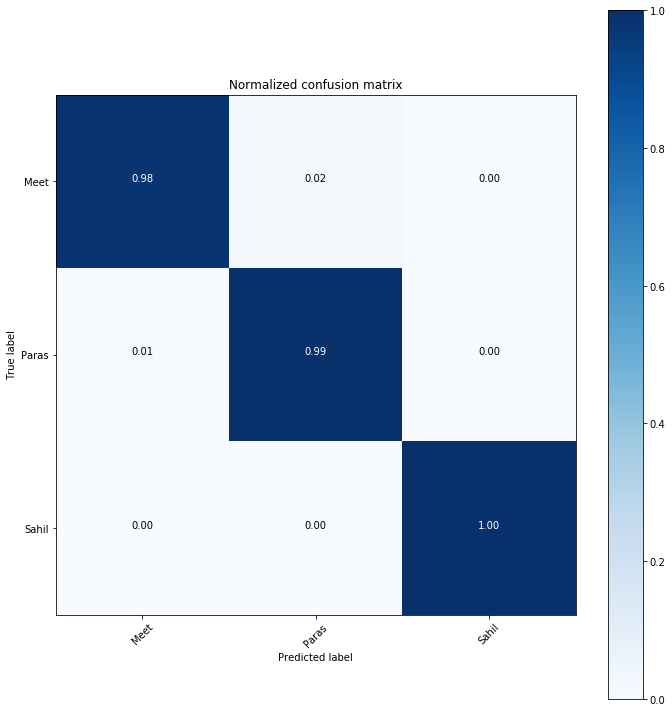

In [86]:
from sklearn.metrics import confusion_matrix
import itertools
class_names = ['Meet', 'Paras', 'Sahil']
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_output)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()